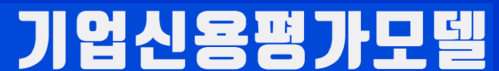

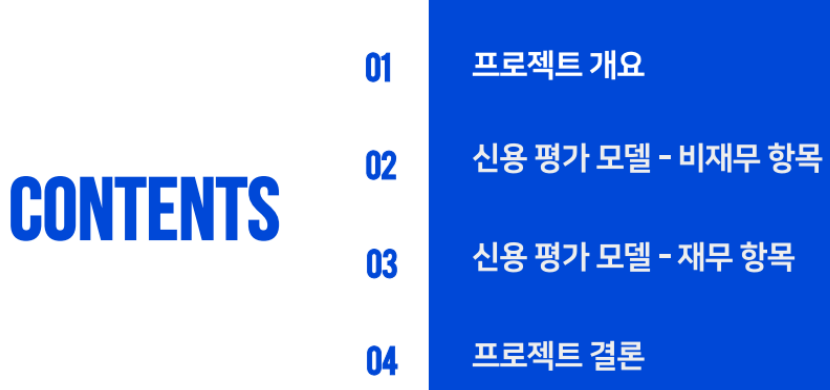

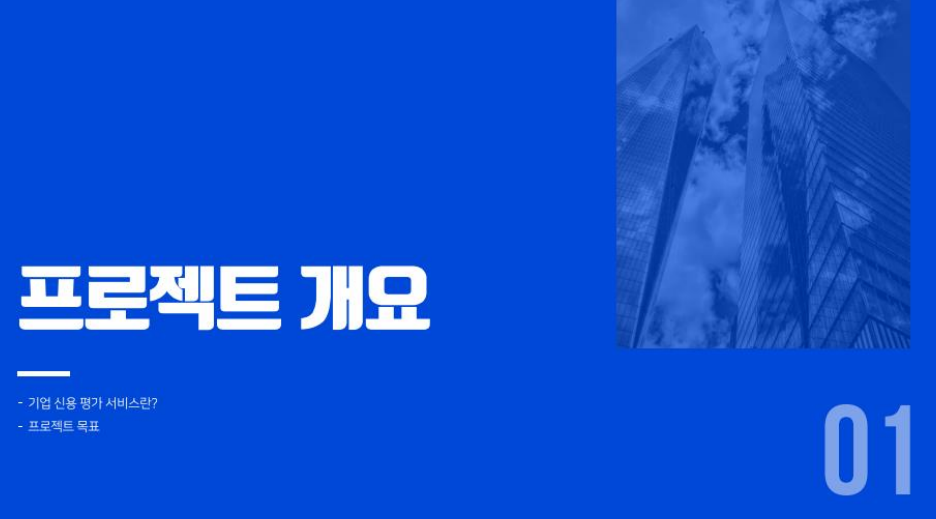

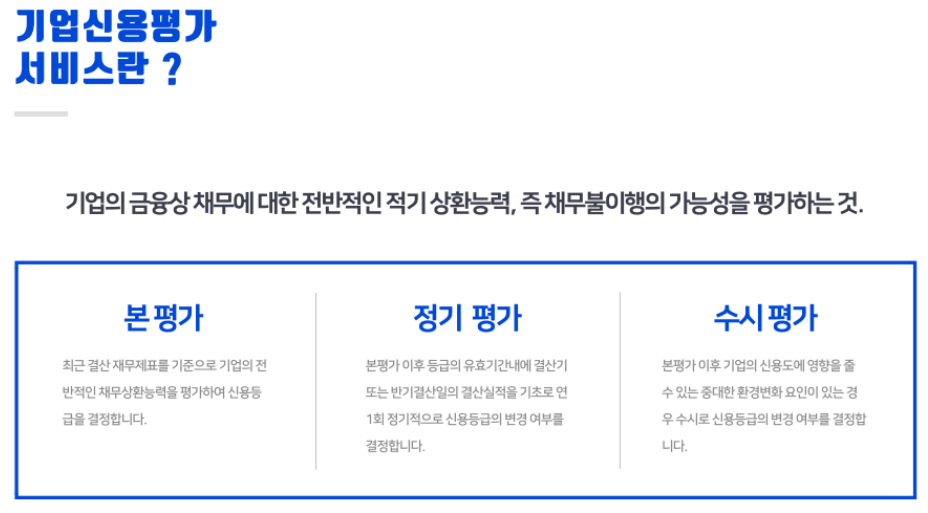

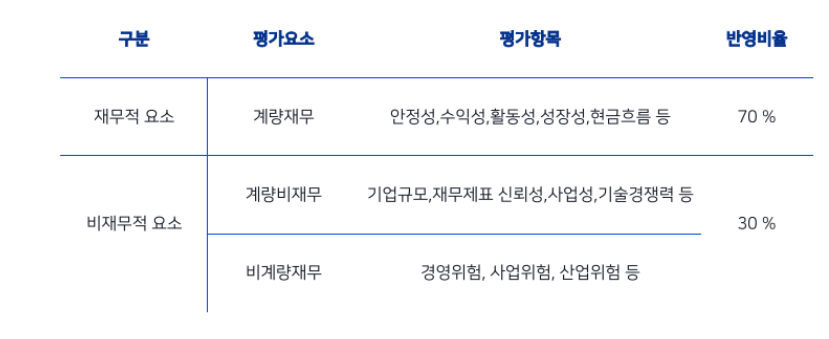

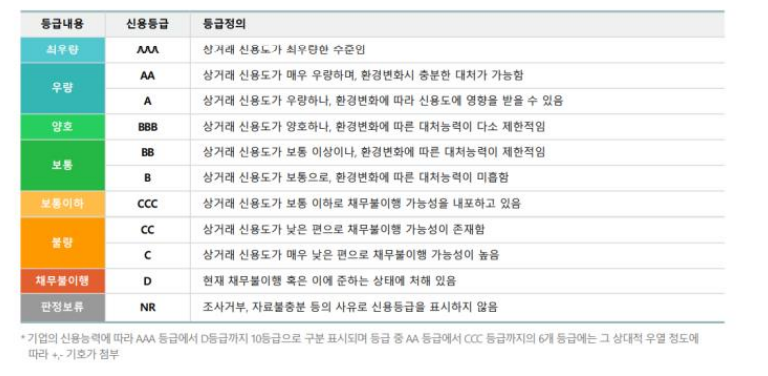

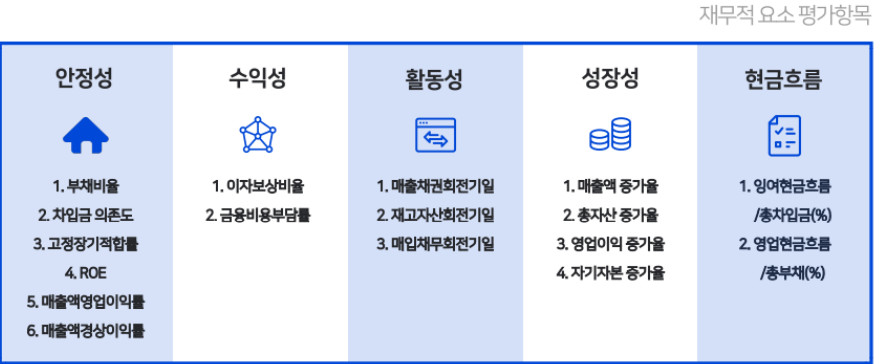

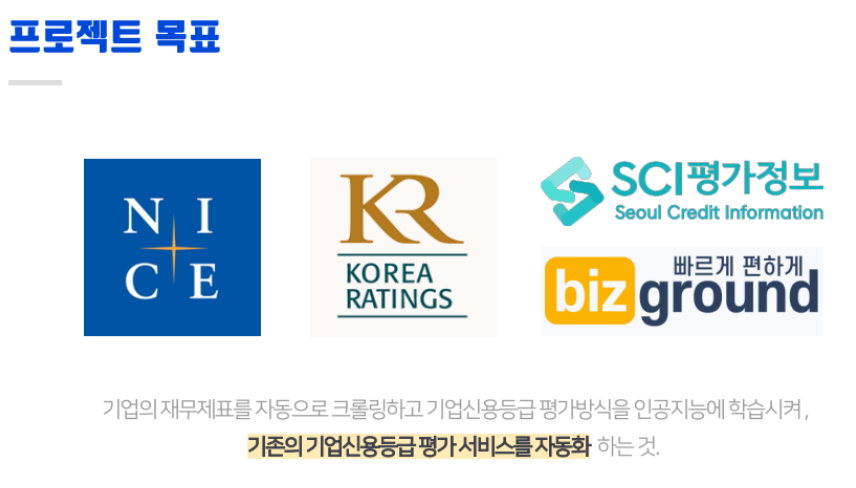

# 비재무 항목 

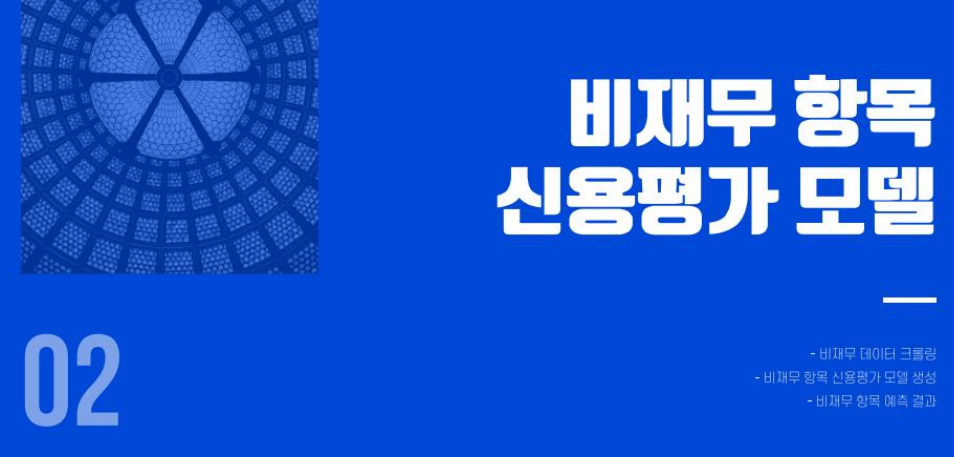

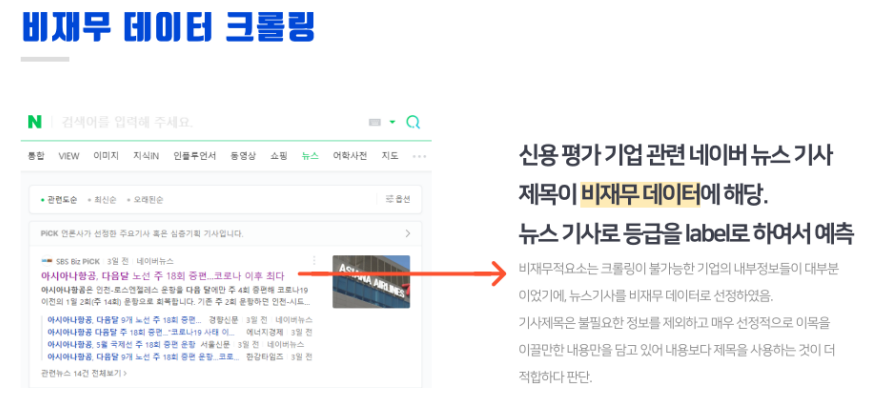



#### train_data = 2008-01-01 ~ 2019-06-24
#### test_data = 2019-06-25 ~ 2022-03-31

In [ ]:
#kb-albert 

In [ ]:
from transformers import AutoTokenizer
model_path = '../input/kb-albert/kb-albert-char-base-v2/kb-albert-char-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
import pandas as pd
import numpy as np
import os
from math import log

import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
df = pd.read_csv('../input/titles-list/titles_list.csv', encoding='cp949')
df_train = df[:980]
df_test = df[980:]

df_test.tail(10)

In [ ]:
# 특수문자및 숫자 제거 (한글만 가져오기)
def preporcess(data):
    preprocess_title = []
    for title in tqdm(data.title):
        doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", title)
        preprocess_title.append(doc)
    return preprocess_title

In [ ]:
# 함수 적용 및 메모리 값을 위한 전처리전의 데이터 drop
df_train['preprocess'] = preporcess(df_train)
df_test['preprocess'] = preporcess(df_test)
df.drop('title',axis=1,inplace=True)
df_test.drop('title',axis=1,inplace=True)

In [ ]:
# 비재무 모델 scoring
def scoring(data):
    fix_credit = []
    for credit in data.target:
        if credit == 'AAA':
            score = 30
            fix_credit.append(score)
        elif credit == 'AA+':
            score = 28.7
            fix_credit.append(score)       
        elif credit == 'AA':
            score = 27.4
            fix_credit.append(score)
        elif credit == 'AA-':
            score = 26.1
            fix_credit.append(score)
        elif credit == 'A+':
            score = 24.8
            fix_credit.append(score)
        elif credit == 'A':
            score = 23.5
            fix_credit.append(score)
        elif credit == 'A-':
            score = 22.2
            fix_credit.append(score)
        elif credit == 'BBB+':
            score = 20.9
            fix_credit.append(score)
        elif credit == 'BBB':
            score = 19.6
            fix_credit.append(score)
        elif credit == 'BBB-':
            score = 18.3
            fix_credit.append(score)
        elif credit == 'BB+':
            score = 17
            fix_credit.append(score)
        elif credit == 'BB':
            score = 15.7
            fix_credit.append(score)
        elif credit == 'BB-':
            score = 14.4
            fix_credit.append(score)
        elif credit == 'B+':
            score = 13.1
            fix_credit.append(score)
        elif credit == 'B':
            score = 11.8
            fix_credit.append(score)
        elif credit == 'B-':
            score = 10.5
            fix_credit.append(score)
        elif credit == 'CCC+':
            score = 9.2
            fix_credit.append(score)
        elif credit == 'CCC':
            score = 7.9
            fix_credit.append(score)
        elif credit == 'CCC-':
            score = 6.6
            fix_credit.append(score)
        elif credit == 'CC+':
            score = 5.3
            fix_credit.append(score)
        elif credit == 'CC':
            score = 4
            fix_credit.append(score)
        elif credit == 'CC-':
            score = 2.7
            fix_credit.append(score)
        elif credit == 'C':
            score = 1.4
            fix_credit.append(score)
        elif credit == 'D':
            score = 0.1
            fix_credit.append(score)
        else:
            print(credit)
    return fix_credit

In [ ]:
df_train['score'] = scoring(df_train)
df_test['score'] = scoring(df_test)

# kb-albert 토큰화 

In [ ]:
def tokenize(data):
    tokenizing = []
    for title in tqdm(data['preprocess']):
        token = tokenizer.tokenize(title)
        tokenizing.append(token)
    return tokenizing

In [ ]:
df_train['token'] = tokenize(df_train)
df_test['token'] = tokenize(df_test)

In [ ]:
df_train.drop('preprocess',axis=1,inplace=True)
df_test.drop('preprocess',axis=1,inplace=True)

In [ ]:
X_train = df_train['token']
Y_train = df_train['score']
print(X_train.shape,Y_train.shape)

In [ ]:
X_test = df_test['token']
Y_test = df_test['score']
print(X_test.shape,Y_test.shape)

In [ ]:
# tensorflow의 tokenizer와 text_to_sequence
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train = pad_sequences(X_train, value=0, padding='pre',maxlen = 15000)
X_test = pad_sequences(X_test, value=0,padding='pre',maxlen = 15000)

In [ ]:
# 모델이 알수있는 데이터로 변환한뒤의 모습
X_train

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier,LGBMRegressor,plot_metric,LGBMRanker
from sklearn.metrics import mean_squared_log_error,accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val , y_train , y_val = train_test_split(X_train,Y_train,test_size=0.15,shuffle=True)
print(x_train.shape, x_val.shape , y_train.shape , y_val.shape)

In [ ]:
# L2 Regularization
lambdas = [0,1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

In [ ]:
lambda_models = []
for lambda_ in lambdas:
    print(f'lambda:{lambda_}')
    model = LGBMRegressor(n_estimators=2000,objective='regression',
                          max_depth=300,device='gpu',n_jobs=-1,metric='l2',
                          num_leaves=31,learning_rate=0.05,reg_lambda=lambda_)
    model.fit(x_train,y_train,eval_set=[(x_val,y_val)],eval_metric=['rmse','mape'],
          early_stopping_rounds=30,verbose=10)
    if lambda_ == lambdas[0]:
        joblib.dump(model,'lgb_0.1pkl')
    if lambda_ == lambdas[1]:
        joblib.dump(model,'lgb_0.2.pkl')
    if lambda_ == lambdas[2]:
        joblib.dump(model,'lgb_0.5.pkl')
    if lambda_ == lambdas[3]:
        joblib.dump(model,'lgb_0.6.pkl')
    if lambda_ == lambdas[4]:
        joblib.dump(model,'lgb_0.7.pkl')
    if lambda_ == lambdas[5]:
        joblib.dump(model,'lgb_0.8.pkl')
    if lambda_ == lambdas[6]:
        joblib.dump(model,'lgb_0.9.pkl')
    if lambda_ == lambdas[7]:
        joblib.dump(model,'lgb_0.99.pkl')
    print('-'*78)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)

In [ ]:
#best lambda 0.5
#KFold validation
lgb_models = []
fold = 1
for (train_idx,valid_idx) in kf.split(X_train,Y_train):
    print('-'*58)
    print(f'Fold:{fold}')
    x_train , x_valid = X_train[train_idx], X_train[valid_idx]
    y_train, y_valid = Y_train.values[train_idx], Y_train.values[valid_idx]
    
    model = LGBMRegressor(n_estimators=2000,objective='regression',
                          max_depth=300,device='gpu',n_jobs=-1,metric='l2',
                          num_leaves=31,learning_rate=0.05,reg_lambda=0.5)
    model.fit(x_train,y_train,eval_set=[(x_val,y_val)],eval_metric=['rmse','mape'],
          early_stopping_rounds=30,verbose=10)
    lgb_models.append(model)
    
    fold += 1

In [ ]:
# validdatin Loss
plot_metric(model,'rmse')

In [ ]:
# ensemble 
ensemble_pred = []
for model in lgb_models:
    pred = model.predict(X_test)
    ensemble_pred.append(pred)
    
ensemble_result = np.mean(ensemble_pred,axis=0)

In [ ]:
ensemble_pred[0]

In [ ]:
result = pd.DataFrame()
result['Y'] = Y_test.values
result['prediction'] = ensemble_pred[0]
# result.reset_index(inplace=True)

In [ ]:
df_test['prediction'] = ensemble_pred[3]

In [ ]:
df_test.drop(['token'],axis=1,inplace=True)

In [ ]:
df_test.to_csv('비재무모델결과.csv',encoding='cp949',index=False)

In [ ]:
df_test

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{'secondary_y':True}]])
fig.add_trace(
    go.Scatter(y=result.Y,name='Target')
)
fig.add_trace(
    go.Scatter(y=result.prediction,name='Y_hat')
)
fig.update_layout(
    yaxis_title = 'Score'
)
fig.show()